# Winter 2021 Shopify Data Science Internship Challenge Solution

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline
sns.set()

## Question 1

A copy of the reference data stored was downloaded and stored at `data/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv` and will be analysed to answer the questions posed.

In [2]:
data = pd.read_csv('data/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')

In [3]:
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [4]:
# Quick check to confirm that there are no missing values in the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


The challenge prompt did mention that there 100 sneaker shops, so I am going to count the number of unique shop_ids as a smell test to give some confidence that the data is indeed what it says.

In [5]:
number_of_sneaker_shops = data['shop_id'].nunique()
print(f"The number of sneaker shops in the dataset is: {number_of_sneaker_shops}")

The number of sneaker shops in the dataset is: 100


Everything looks good with the data thus far. As the first step in the analysis, I want to compute the Average Order Value (AOV) as described in the question prompt. 

In [6]:
# Make a datetime index from the `created_at` column to make time-series analysis easier
data.index =  pd.to_datetime(data['created_at'])

In [7]:
# Check for the time period in the dataset
data.index.max(), data.index.min()

(Timestamp('2017-03-30 23:55:35'), Timestamp('2017-03-01 00:08:09'))

All of the transactions in the dataset occured within March 2017, so the Month grouping wouldn't make much difference, but would not hurt either. We can compute the average of order_amount as below.

In [8]:
AOV = data.groupby(pd.Grouper(freq='M'))['order_amount'].mean().values[0]
print(f"The Average Order Value is: ${AOV:.2f}")

The Average Order Value is: $3145.13


### 1a)

A few things come to mind when thinking of the average order value calculated above:

* are there any outliers orders of very high amounts that may be pulling the average up?
* what metric are we really trying to compute? Some measure of the value of each unit of item ordered or some measure of the total value of each order?
* does the order_amount represent the total value of each order? If yes, then we would need to consider the quantity of items ordered, if we wanted to get a sense of the value of each item in the order ? 

The first step in search of a solution, is to look at the distribution of order amount, via a histogram.

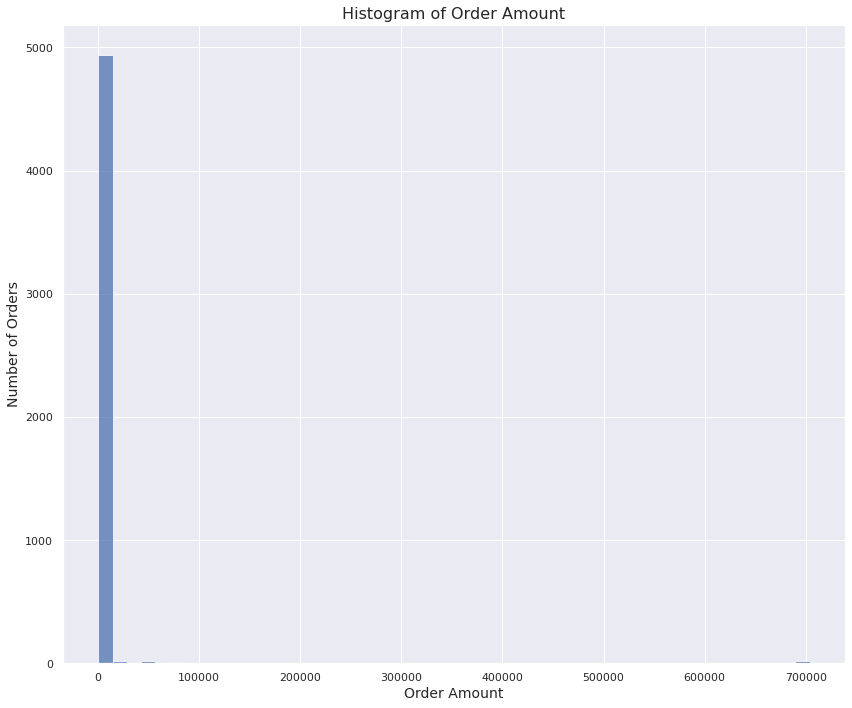

In [9]:
# Plot histogram of Order_amount
fig, ax = plt.subplots(1,1, figsize=(12, 10), tight_layout=True)
n, bins, patches = ax.hist(data['order_amount'], 50, facecolor='b', alpha=0.75)


plt.xlabel('Order Amount', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14, )
plt.title('Histogram of Order Amount', fontsize=16)
plt.grid(True)
plt.show()

We can see from the histogram above that even though most of the orders are less than 50,000 in value, there are outliers lieing close to 700,000. These outliers will definitely skew the averages we calculate and are the reason we are getting such a high average order value.

We can zoom into these high value orders, to see if we can get a sense of why there are sneaker orders costing so much.

In [10]:
# Check for orders with value greater than $100K
data.query('order_amount > 100_000')

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
created_at,,,,,,,
2017-03-07 04:00:00,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
2017-03-04 04:00:00,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
2017-03-02 04:00:00,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
2017-03-27 22:51:43,692,78,878,154350,6,debit,2017-03-27 22:51:43
2017-03-24 04:00:00,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00
2017-03-15 04:00:00,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00
2017-03-11 04:00:00,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00
2017-03-19 04:00:00,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00
2017-03-17 04:00:00,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00


We see that majority of these orders are for a large quantity of items, which suggests that looking at the value of each item in the order, rather than the total order value might be one approach to consider.

### 1b & 1c

Ultimately, how we choose to address the issues highlighted above would depend on what metric we are really trying to compute here. If the interest is in the central tendency of total values of orders, irrespective of the number of items in the order, then looking at the median order value would be one potential way to discount the effect of the outliers.

However, the question prompt did mention that we have an expectation that the Average Order Value would be lower, since Sneakers are relatively inexpensive items. This suggest to me that we are really interested in the Average value of each item ordered from the Sneaker shops within the one-month period. 

Assuming then that we want to calculate an average Value of each unit of item ordered within the period, we can calculate the unit price of each item ordered by dividing the order amount by the quantity of items ordered, and then calculate our average using this calculated column as shown below. This would represent the `Average Revenue Per Unit(ARPU)` across all the sneaker stores.

In [11]:
data['order_unit_value'] = data['order_amount'] / data['total_items']

In [12]:
ARPU = data.groupby(pd.Grouper(freq='M'))['order_unit_value'].mean().values[0]
print(f"The ARPU is: ${ARPU:.2f}")

The ARPU is: $387.74


In summary, the **Average Revenue Per Unit(ARPU)** might be a better metric, and the value of this metric across all stores is **$387.74**

## Question 2

To make this part of the analysis easily reproducible, I decided to re-create the reference database as a SQLite database, and then run my queries here against this database.

To do this, I copied the data from the database tables into CSV files, and then developed a Python script that creates the database and required tables, with a minimum viable schema. The `create_tables.py` file accomplishes this.

Once the database has been re-created, running `etl.py` copies the data from the CSV files into the appropriate database tables. A copy of the database has been uploaded along with the relevant scripts to the repo containing this notebook.

In [13]:
# Connect to the database
conn = sqlite3.connect('orders_data.sqlite')
cur = conn.cursor()

### 2a) Number of Items Shipped by Speedy Express

In [14]:
QUERY_1 = """SELECT count(OrderID) FROM Orders
WHERE ShipperID = 
(SELECT ShipperID from Shippers WHERE ShipperName = 'Speedy Express');"""

In [15]:
cur.execute(QUERY_1).fetchall()[0][0]

54

**Speedy Express** shipped a total of **54 orders**.

## 2b) Last Name of the employee with the most orders

In [16]:
QUERY_2 = """SELECT LastName
FROM Employees 
WHERE EmployeeID = 
(SELECT EmployeeID
FROM Orders
GROUP BY EmployeeID
ORDER BY COUNT(EmployeeID) DESC
LIMIT 1);"""

In [17]:
cur.execute(QUERY_2).fetchall()[0][0]

'Peacock'

The employee with the most orders had the last name **Peacock**

N/B: The reference database provided in the challenge was an SQL Server/MS Access, which doesn't support the LIMIT clause. The query below would produce the same result

In [18]:
ALTERNATIVE_QUERY_FOR_MS_ACCESS = """SELECT LastName
FROM Employees 
WHERE EmployeeID = 
(SELECT TOP 1, EmployeeID
FROM Orders
GROUP BY EmployeeID
ORDER BY COUNT(*) DESC);"""

## 2c) Product ordered the most by customers in Germany

In [19]:
QUERY_3 = """SELECT sub.ProductName FROM
(SELECT Products.ProductName, SUM(OrderDetails.Quantity) AS quantity_ordered
FROM Products INNER JOIN OrderDetails ON 
Products.ProductID = OrderDetails.ProductID
WHERE OrderDetails.OrderID IN 
(SELECT Orders.OrderID FROM Customers
INNER JOIN Orders ON Customers.CustomerID = Orders.CustomerID
WHERE Customers.Country = 'Germany')
GROUP BY Products.ProductName
ORDER BY 2 DESC
LIMIT 1) sub;"""

In [20]:
conn.execute(QUERY_3).fetchall()[0]

('Boston Crab Meat',)

**Boston Crab Meat** was ordered the most by customers in Germany